In [45]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from rich import print
from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [46]:
data_path = '../../data/result/bertopic_labels-manual-reduction.csv'

In [47]:
data = pd.read_csv(data_path)

In [48]:
data.tail()

,column,text,topic_id
1605,add_suggestions,يوجد غموض كبير في مقرر المادة من قبل الدكتور ف...,4
1606,like,يوفر تاسيس جيد بالنسبة للمستوى الميتدأ,-1
1607,like,يوفر كل ما يحتاجه الباحث من أجل عمل محاكاة بصو...,3
1608,like,يوفر معرفة ممتازه,0
1609,improve_course,يومين في الأسبوع أو يوم,8


In [49]:
data.isna().sum()

column      0
text        0
topic_id    0
dtype: int64

In [50]:
len(data[data['topic_id'].isin([4, 7, -1])])

217

In [51]:
sorted(data['topic_id'].unique())

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [52]:
topic_dict = {
    f'topic_{str(i)}': data[data['topic_id']==i]['text'].tolist() for i in data['topic_id'].unique() if i not in(-1, 4, 7)
}

In [53]:
for k in topic_dict:
    print(k)
    print(topic_dict[k][:2])

topic_1

[
    '- dr. emad is a professional in everything (explaining, organizing, supporting, [رابط])-this course is 
improved my skills',
    'a good start to the program.'
]

topic_0

['1-التدريب على الأسئلة 2-التدريب على الأفكار الجديدة', 'a lot of valuable info']

topic_3

[
    "add a lab lecture for this course in order to get the instructor ' s help and supervision during programming",
    'add a lab lecture increase the course hours'
]

topic_2

['all about the course', 'all of the things']

topic_8

['exam timing is little', 'little bit long']

topic_5

['final project', 'huge and overload amount of tasks that are not suitable for presented content']

topic_9

['how relevant it is to the workplace', 'new in the techneaque world']

topic_6

['only one professor gives the course', 'professor knowledge']

topic_10

['أبدا ماده علميه محكمه مقننه جباره', 'أسلوب تقديم المادة العلمية']

In [54]:
model_path = 'sentence-transformers/use-cmlm-multilingual'
embedding_model = SentenceTransformer(model_path)

/home/elshehawy/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at sentence-transformers/use-cmlm-multilingual were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model t

In [55]:
embed_dict = {}
device = 'cpu'
for topic_id, text in tqdm(topic_dict.items()):
    embed_dict[topic_id] = embedding_model.encode(text, device=device, show_progress_bar=False)

100%|████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  1.75s/it]


In [56]:
embed_dict['topic_0'].shape

(448, 768)

In [57]:
embed_dict_mean = {k: v.mean(axis=0) for k, v in embed_dict.items()}

In [58]:
embed_dict_mean['topic_0'].shape

(768,)

In [59]:
topic_keys = sorted(embed_dict.keys())
print(topic_keys)

['topic_0', 'topic_1', 'topic_10', 'topic_2', 'topic_3', 'topic_5', 'topic_6', 'topic_8', 'topic_9']

In [60]:
topic_embddings = [embed_dict_mean[key] for key in topic_keys]

In [61]:
target_idx = [4, 7, -1]
outlier_topics_index = data[data['topic_id'].isin(target_idx)].index.tolist()
outlier_topics_text = data[data['topic_id'].isin(target_idx)].text.tolist()
outlier_topics_embeddings = embedding_model.encode(outlier_topics_text, device=device, show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [62]:
similarities = cosine_similarity(outlier_topics_embeddings, topic_embddings)

In [63]:
similarities.shape

(217, 9)

In [64]:
1/9

0.1111111111111111

In [65]:
def argmax(arr, num_cols, threshold=0.0):
    idx = []
    for row in arr:
        assert len(row) == num_cols
        i = -1
        if np.max(row) >= threshold:
            i = np.argmax(row)
        
        idx.append(i)
    return np.array(idx)

In [66]:
threshold = 0.22
max_similarities_idx = argmax(similarities, 9, threshold=threshold)

In [67]:
max_similarities_idx

array([ 6,  6,  6,  1,  1,  1,  1,  1, -1,  1,  6, -1, -1, -1,  0,  6, -1,
        1,  6, -1, -1, -1, -1,  6,  6,  6,  0,  1,  5,  0,  0,  1,  1,  1,
        1,  1,  1,  0, -1,  1,  1,  0,  6,  6,  4,  6,  1,  6,  6,  6,  6,
        6,  6,  0,  4,  1,  6,  1,  6, -1,  2,  1,  1,  0,  6,  1,  6,  1,
        0,  1,  6,  1,  6,  1,  6, -1, -1,  6,  6,  1,  6,  1,  1,  1,  6,
        1,  1,  1, -1,  6,  1,  1,  6,  6,  1,  6,  1,  4,  6,  1,  7,  0,
        1,  6, -1,  2,  4,  6,  2,  0,  6,  0,  6,  1,  2,  0,  0,  6,  6,
        0,  6,  5,  6,  6,  6,  8,  6,  7,  2,  2,  5,  1,  7,  0,  6,  2,
        0,  4,  0,  1,  6,  6,  6,  6,  1,  1,  1,  6,  1, -1,  1,  5,  1,
        0,  6,  6,  1, -1,  6,  6,  6, -1,  6,  0,  0, -1,  6, -1,  6,  1,
       -1,  5,  1,  6,  6,  1,  1, -1,  6,  6,  6,  1,  6,  1,  1,  0,  4,
        1,  1,  6,  1,  6,  1,  6,  6,  0,  6,  6,  5,  0,  6,  1,  1, -1,
        0,  5,  6,  6,  6, -1,  6,  1,  6,  4, -1,  6,  0])

In [68]:
new_topics = [topic_keys[i] if i!=-1 else 'topic_-1' for i in max_similarities_idx]
print(new_topics[:6])

['topic_6', 'topic_6', 'topic_6', 'topic_1', 'topic_1', 'topic_1']

In [69]:
new_topics = [int(topic_name.split('_')[-1]) for topic_name in new_topics]

In [70]:
print(new_topics[:20])

[6, 6, 6, 1, 1, 1, 1, 1, -1, 1, 6, -1, -1, -1, 0, 6, -1, 1, 6, -1]

In [71]:
df = data.copy()

########## Topics After Merging From Last Step ##########
0 محتوى ومعلومات المقرر
1 دكتور المقرر
2 None
3 موازنة الجزء العملي مع الجزء النظري 
4 = 2 before merging
5 المتطلبات و المهام و الدرجات
6 طريقة تدريس و تقديم المادة
7 = 9 before merging
8 الوقت و الجدول
9 سوق العمل
10 الجانب البحثي و الأوراق البحثية
###########################################

In [72]:
df.loc[outlier_topics_index, 'topic_id'] = new_topics

In [73]:
len(df[df['topic_id'].isin([-1])])

25

In [75]:
len(data[data['topic_id'].isin(target_idx)])

217

In [77]:
df['topic_id'].unique()

array([ 1,  6,  0,  3,  2, -1,  8,  5,  9, 10])

In [78]:
# print(df[df['topic_id']==-1]['text'].tolist())

In [79]:
topic_names_dict = {
    -1: "Outlier",
    0: "محتوى ومعلومات المقرر", 
    1: "دكتور المقرر", 
    2: "None", 
    3: "موازنة الجزء العملي مع الجزء النظري", 
    5: "المتطلبات و المهام و الدرجات", 
    6: "طريقة تدريس و تقديم المادة", 
    8: "الوقت و الجدول", 
    9: "سوق العمل", 
    10: "الجانب البحثي و الأوراق البحثية"
}

In [80]:
df['topic_name'] = df['topic_id'].apply(lambda x: topic_names_dict[x])

In [81]:
for i, row in df.loc[outlier_topics_index, :].iterrows():
    print(row['text'], f"Topic is: {row['topic_id']}-{row['topic_name']}", sep='\n\t')

- إعطاء مشاريع صغيرة بدلا من مشروع كبير-يكون الغرض التركيز على إكساب الطلبة المهارات الأساسية نظرا لعدم دراسة هذه 
المادة سابقا في البكالوريس
        Topic is: 6-طريقة تدريس و تقديم المادة

- التركيز على إعطاء الطلبة خلفية جيدة عن تعلم الالة بشكل واضح وبسيط وتوقعانهم أول مرة يدرسوها
        Topic is: 6-طريقة تدريس و تقديم المادة

- عمل منهج واضح بالنسبة للطلاب ومحدد-إيضاح طريقة التقييم-دمج محتوى المنهج مع ما ناخذه كطلاب علوم حاسبات في المواد 
الأخرى
        Topic is: 6-طريقة تدريس و تقديم المادة

1-the verity of tools that we used and applied 2-knowing how to access aziz in data processing 3-having 3 
presentations during the semester about the the topic that i am focusing on was improved my presenting skills. 
4-[رابط] was so cooperative in term of specifying the dates and deadlines for our work and presentations.
        Topic is: 1-دكتور المقرر

1-المنهج والمحتوى جميل ومفيد 2-فكره تطبيق أغلب المواضيع تطبيق عملي وياليت تكون أكثر ويلغى الاختبار النظري لانه 
لايرجع بفائه مثل التطبيق العملي وهو الأهم
        Topic is: 1-دكتور المقرر

1-تحسين أسلوب دكتوره الماده في التعامل 2-التقليل من كمية و صعوبة البحث المطلوب 3-وضع وصف واضح للنقاط المطلوبة في 
الواجبات 4-تعديل مخطط المقرر ليحتوي على مخرجات التعلم و أشياء أخرى
        Topic is: 1-دكتور المقرر

1-شمولية المقرر 2-المام الدكتور عبدالله وشرحة التفاعلي داخل المحاضرات 3-المشاريع التي طلبت منا ذات جوده وقيمة علميه
عاليه
        Topic is: 1-دكتور المقرر

aziz wan ' t accessible from the university internet which prevent us from taking enough practice on it
        Topic is: 1-دكتور المقرر

demonstrate how all the learned techniques can help in area of research especially relating to computer science.
        Topic is: -1-Outlier

dr. maha is soo wonderful and has an interesting style and is keen to open channels of communication with the 
students at all times and respond to all inquiries with love and high professionalism
        Topic is: 1-دكتور المقرر

engaging lectures and projects.
        Topic is: 6-طريقة تدريس و تقديم المادة

enhancements in the availability and accessibility of technical resources, including software tools, development 
environments, and hardware, would further support students in their software engineering learning journey.
        Topic is: -1-Outlier

i liked the multiple short quizzes instead of one long exam.
        Topic is: -1-Outlier

please give the material to a person who is specialized in it for the ease of communicating the information to the 
student and in order to help the student to apply in the subject. unfortunately, the doctor, who submits the 
material only reads from the slides and comes with a request from outside the curriculum. we have not trained to 
solve it. in addition to checking the correction of duties with science. this subject before you study, it is 
necessary to study mathematics and statistics and has requirements, in addition to the teacher ' s failure to take 
into account the students. i hope that a survey and survey will be taken from the students who took the subject to 
make sure of what i said.
        Topic is: -1-Outlier

that this course helped me to have as skills in very important part in cybersecurity wiches writing policy
        Topic is: 0-محتوى ومعلومات المقرر

the amount of material i had study in this course was not reasonable and not enough for the credit hours allocated.
        Topic is: 6-طريقة تدريس و تقديم المادة

the content of course it 's seems a ph. d. (image processing), not (computer vision) also the way of the final exam
it' s not a good experience.
        Topic is: -1-Outlier

the course content may not very helpful and related to the real work environment. the course syllabus was not 
available.
        Topic is: 1-دكتور المقرر

the course materials and assignments and projects
        Topic is: 6-طريقة تدريس و تقديم المادة

the encryption the first assignment was about encrypting and decrypting. on the first question we had to decrypt a 
key and it was enjoyable since i enjoy encrypting the decrypting "remember to keep the secret key secret"<- this 
was our first decryption in course
        Topic is: -1-Outlier

the gap between the lectures and the exams! what we do in a whole semester is practice and programming (on device) 
in the final exam builds a website front and backend (on paper) with every detail!! this type of course is not 
suitable for exams on paper in 90 mins!
        Topic is: -1-Outlier

the instructor. when we ask about how to do assignments he keep saying i will give you a for all of you don 't 
worry and he didn' t explain the assignments very well. he just say do your best in anyway. also he didn ' t give 
us assignments grades immediately. we submit the final report without knowing what are our grades in the previous 
assignments. he didn’ t provide us with a tool to check plagiarism as other courses and he didn’ t explain how he 
will mark or check our work
        Topic is: -1-Outlier

the lab activity grades since it counted on having no errors so i lost some marks due to installation errors and in
progress errors
        Topic is: -1-Outlier

the quizes were not schedualed appropriately throughout the semester, and not correctly and fairly graded. the 
instructor was not available and not commited to the course time. difficult to communicate with her.
        Topic is: 6-طريقة تدريس و تقديم المادة

the subject teacher, the reason, is not able to do the subject and read the slides. there are no examples to which 
we apply and train, and in the tests, he comes with a question from outside the curriculum, we did not train.
        Topic is: 6-طريقة تدريس و تقديم المادة

the syllabus has to be apparent from the beginning of the course, and the teacher should have the ability to give 
and explain the right answers to the tests and assignments.
        Topic is: 6-طريقة تدريس و تقديم المادة

the syllabus is clear and well organized
        Topic is: 0-محتوى ومعلومات المقرر

the teaching method inside the class was so inspiring and interactive, and i learnt from the prof rizwan how to 
make a scientific research and i was able to publish a paper after the course
        Topic is: 1-دكتور المقرر

آلية التصحيح للاختبارات ليس بها شفافية
        Topic is: 5-المتطلبات و المهام و الدرجات

آماد أجزم بأن هذه المادة حببتني في كل ما يخص مجال الأمر السيبراني. أستفدت منها الكثير في تطوير مهاراتي لزيادة أمان 
شبكات الإنترنت لدي
        Topic is: 0-محتوى ومعلومات المقرر

أتمنى دراسة هيئة الأمن السيبرانب السعودية وفهم طبيعة عملها، وتحليل موقعها واصداراتها والمتابعة أكثر لها خلال دراسة 
هذه المادة، واعتماد nca كمرجع للمعايير والضوابط مثل المعايير العالمية ك nist وغيرها
        Topic is: 0-محتوى ومعلومات المقرر

أتمنى لو كان فيه تطبيق عملي بشكل أكبر وأكثر ولكن د سحر بدري من أروع الدكاتره لتوسيع معرفتنا في مادة الشبكات والبحث 
فيها لزيادة معرفتنا
        Topic is: 1-دكتور المقرر

أتمنى يتم ربط الشرح بفيديوهات يسهل فهمه واستيعابه
        Topic is: 1-دكتور المقرر

أستاذة المادة متحمسة للمادة وتعطي بإخلاص وإتقان وتبذل جهدها في إيصال المعلومة بشتى الوسائل والمادة محتواها خفيف 
ومباشر ومهم جدا
        Topic is: 1-دكتور المقرر

أستاذة المادة متحمسة للمادة وتعطي بإخلاص وإتقان وتبذل جهدها في إيصال المعلومة بشتى الوسائل والمادة محتواها رغم طوله
مهم جدا والدكتورة تركز على الجانب التطبيقي بشكل مطابق للواقع وسوق العمل
        Topic is: 1-دكتور المقرر

أسلوب الدكتور لا يكن مناسب لمحتوى المداة. البيانات التي قدمت للطالب في بداية الفصل كانت تاريخية قديمة جدا.
        Topic is: 1-دكتور المقرر

أعطى الطالب القدره على فهم عمل الشبكات وكيفيه إدارتها وتتبع حركة نقل البيانات مع خلال تطبيقات التقنية وساهم البحث 
العلمي للماده بتزويد الطالب بمزيد من المعرفة في أنظمة الشبكات وكيفية تطويرها من خلال تقينيات التشفير المعتمده 
بالإضافة الى كيفية حماية المواقع من الهكر
        Topic is: 1-دكتور المقرر

أعطى الطالب المعرفة الشاملة بتمطلبات الأمن السيبراني والقدره اعدادها والتخطيط لها وإيجاد الحلول المناسبه والموثوقه 
لتفادي الهجمات السيبرانيه وسد الثغرات في الانظمه بااستخدام السياسات والتقنية وفق المعايير الدوليه والاقليميه 
لسياسات وإجراءات الأمن السيبراني
        Topic is: 0-محتوى ومعلومات المقرر

أفترح أن تكون المعلومات التاريخية مجرد اطلاع لكونها كثيرة وهي مفيدة لمجرد العلم بالشيء. فهي لا تواكب محتوى المادة 
العصرية.
        Topic is: -1-Outlier

أفضل ما تم تعليمه هو طريقة عمل سياسة للمنظمه (طريقة ربط المعلومات بمحاكاة العمل الحقيقي كانت طريقة جميله جميله وتم 
ممارستها بشكل تلقائي واستفدت منها بالعمل وأيضا طريقة كتابة السياسه بطريقة سهله وبسيطه ومفهومه وصحيحه زادت من مهارات
الكتابه لنا أشكر د عفراء على دقتها في ذلك
        Topic is: 1-دكتور المقرر

أكثر ما اعجبني له علاقة بأحد طرق تقييم المقرر وهو البحث عن أوراق بحثية وشرحها ومناقشتها طورت جدا مهاراتي البحثية 
بشكل كبير
        Topic is: 1-دكتور المقرر

أهمية المعلومات المقدمة لي كطالب للعلم
        Topic is: 0-محتوى ومعلومات المقرر

إتاحة الفرصة لطلبة الدراسات العليا لتعلم مهارات مهمة عن طريق ممارستها مثل القراءة السريعة وتلخيص العروض وإعدادها 
والنقد والاستنتاج وقراءة أوراق علمية عالية التأثير وإمكانية إضافة معلومات عنها أو عن ما يتعلق بالمادة في ساحة 
الحوار ومناقشته
        Topic is: 6-طريقة تدريس و تقديم المادة

إسناد المقرر لمعلمين يتحدثون اللغة العربية (الأم)، نظرا لما تحتويه من مصطلحات رياضية بكثرة مثل (القيمة الأسية-الجذر
التربيعي-الانحراف المعياري-التباين.. الخ) حيث سيساهم ذلك في تسهيل العملية التعليمية للطلاب.
        Topic is: 6-طريقة تدريس و تقديم المادة

إضافة جزء عملي مهم جداا. لأن دراسة التشفير نظريا صعب نوعا ما ولكن مع التطبيق العملي راح تثبت المعلومة أكثر
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

إضافة دورات اجبارية لاجتياز المقرر للمهارات المطلوبة لإتمام الرسالة مثل التعامل مع البيانات وتجهيزها للبحث و مهارات
الكتابة العلمية والكتابة باستخدام اللاتكس وغيرها إضافة دورات عملية مختلفة للمجالات التقنية مثل الذكاء الاصطناعي 
وتنقيب البيانات والمجالات الأخرى
        Topic is: 6-طريقة تدريس و تقديم المادة

إضافة طرق أفضل واحترافية أكثر من التي تم تدريسها في المنهج وتعلم برامج جديدة وتوافر دكاترة أسلوبهم جيد ويحببونك في 
المادة وليس العكس
        Topic is: 1-دكتور المقرر

إعادة ترتيب المحتوى والمتطلبات بناء على أهميتها في الأبحاث وأيضا توفير مصادر للطلاب أغلب المصادر والمعلومات الحديثه
لا توفرها الجامعة للطالب أو الاشتراك يكون محدود أو عن طريق ايميل يرسل للمنسوبين وهذا يعطل ويقلل من جودة الأبحاث
        Topic is: 6-طريقة تدريس و تقديم المادة

إعادة توزيع الدرجات بما يتناسب مع قدر العمل توضيح تفاصيل المشروع مع بداية الترم لما فيه من الاعتماد الكبير في 
جزئيات كبيرة على المواد السابقة تحسين أسئلة الاختبار بما يتناسب مع طبيعة المادة وبالتالي لا تكون الاختبارات عبارة 
عن حفظ للمعلومات ولكن تفهم
        Topic is: 6-طريقة تدريس و تقديم المادة

إلزام عضو هيئة التدريس بالتطبيق العملي على برنامج واير سارك وليس شرحه نظريا دون التطبيق مع الطالبات شرح 
اللوغاريتمات بالتفصيل حيث لم يتم ذلك.
        Topic is: 6-طريقة تدريس و تقديم المادة

إلغاء المادة من برنامج الماجستير التنفيذي للأمن السيبراني كونها مادة إدارية يستطيع الطالب أخذها كدورة من أي مكان 
آخر، أو جعلها اختيارية وترك المجال للطلاب لاختيارها أو لا.
        Topic is: 6-طريقة تدريس و تقديم المادة

استبدال هذا المقرر بمقرر آخر من المقررات الاختيارية
        Topic is: 6-طريقة تدريس و تقديم المادة

اضافه الماده كل سنه فهي ماده مفيده وفيها مجال للابداع وتضيف للطالب مواضيع مهمه للرساله
        Topic is: 6-طريقة تدريس و تقديم المادة

اعتقد ان ترم واحد لايكفي للتشبع من المادة
        Topic is: 0-محتوى ومعلومات المقرر

اعتماد الأمثلة والرسم في الشرح لتبسيط المعلومة
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

اعجبتني مواضيع المقرر مفيده وتغطي أهم النقاط التي من خلالها أستطيع التعمق والبحث في المجال
        Topic is: 1-دكتور المقرر

اقتراحياننا نأخذ حاله واحده، ويتم تطبيق عليها جميع محاور الدروس التي تم أخذها.. حتى يتضح لنا في كل خطوه كيف يصبح 
دراسة الحاله
        Topic is: 6-طريقة تدريس و تقديم المادة

اقترح على دكتور المادة أن يبدا مع الطلاب بشكل مبسط لكون المادة معقدة وقد تنقص الطالب بيانات كبيرة. الفجوة بين 
المادة والمعلومات التي عند الطالب كبيرة جدا. وخصوصا أن الدكتور يعطي معلومات تاريخية قديمة جدا والتي ترجع الى بدايات
نشأت الحاسب.
        Topic is: 1-دكتور المقرر

ال-جعل المنهج واضح بالنسبة للطلاب-إيضاح طريقة التقييم-دمج محتوى المنهج مع ما ناخذه كطلاب علوم حاسبات في المواد 
الأخرى خاصة وان المادة تعتبر العمود الفقري لعلوم حاسب
        Topic is: 6-طريقة تدريس و تقديم المادة

الأسئلة كانت بطريقه الاختيار من متعدد ولو كان هناك نوع آخر إضافي لكان أفضل.
        Topic is: -1-Outlier

الأنشطة المرافقة للمادة كانت قراءة بحث علمي وتلخيصه، مما ساعد على ان نفهم الأوراق العلمية
        Topic is: 10-الجانب البحثي و الأوراق البحثية

الإلمام ب أنواع الاتاك في الويب سكيورتي وطريقة تطبيقه بشكل علمي وطريقة د سعاد في طرح المادة العلمية كانت جداا 
مفيدده سهلت علينا فهم الماده رغم صعوبتها
        Topic is: 1-دكتور المقرر

الاستناد على كتاب واضح ويكون الشرح متسلسل من هذا الكتاب
        Topic is: 1-دكتور المقرر

الاضلاع على نماذج إستراتيجيات أمن سيبراني لشركات كبرى، وطريقة صياغة الضوابط، وشركات المراجعة والتدقيق ودراسة أحد 
النماذج
        Topic is: 0-محتوى ومعلومات المقرر

الانتباه الى ان الطلبة لا يملكون خلفية تقنية عن الخوارزميات المستخدمه في المادة وبالتالي التركيز ايضا على تدريبهم 
عمليا
        Topic is: 6-طريقة تدريس و تقديم المادة

التاسكات في البداية كانت غير مربوطة بشكل كافي بالمقرر، لو يكون في تدريب عملي في اللقاءات
        Topic is: 1-دكتور المقرر

التركيز ع النمذجه والمحاكاه كاسلوب بحثي بدلا من التركيز ع الأسلوب الرياضي وان تتناسب الواجبات مع أهداف المقرر
        Topic is: 6-طريقة تدريس و تقديم المادة

التركيز على العميق بدل المقدمات العامه للذكاء والتي يفترض من طلاب الدكتوراه معرفتها
        Topic is: 1-دكتور المقرر

التركيز على هذا المقرر بزيادة محتواه أو إضافة مقرر آخر يدور حول المخاطر
        Topic is: 0-محتوى ومعلومات المقرر

التطبيق العملي طيلة الخطة منذ اللقاءات الاولى وموائمة السلايدات مع الخطوات العملية على التولز بشكل واضح ومشاركة 
العمل مع الدكتورة خطوة بخطوة لكل طالبة
        Topic is: 1-دكتور المقرر

التغذية الراجعة على الأبحاث والواجبات للمقرر، إتاحة الفرصة للتعلم عن تلخيص ونقد الدراسات السابقة. إتاحة الفرصة 
لتعلم كيفية إعداد بحث في المجال بالتدريج
        Topic is: 6-طريقة تدريس و تقديم المادة

التقييم الأمني من أهم أهم أهم المواد العلمية اللي تم تقديمها في هذا البرنامج وتمكن د بسمه السلمي من إعطاء المادة 
العلمية زادت معرفتنا فيها بشكل ممتع وطريقة العملي كانت فيه جميله وتم الاستفاده منها في أرض العمل
        Topic is: 1-دكتور المقرر

التكاليف في هذه المادة فرديه بالتالي تزيد من وعي و معرفة الطالب و الحفاظ على حقه من ناحية الدرجات
        Topic is: 6-طريقة تدريس و تقديم المادة

الدكتورة متفهمه ومنصفه جدا وملمه بمحتوى المادة وطريقة استخدامه في الواقع وكثير ما كانت تربط المادة بالواجع بشكل 
مذهل وجدا ساهم في فهم الطلاب لمفاهيم المادة ايضا خلال المقرر قمنا بكتابة ورقة علمية عن موضوع لم نتطرق له كثيرا في 
المحاضرات مما ساهم في زيادة قدرة الطالبات على الفهم والاستنتاج وتربيط المعلومات بشكل جدا كبير
        Topic is: 1-دكتور المقرر

الرجاء تنسيق الخطه الدراسيه لان كانت برمضان فقط محاضره مما سبب ضغط بعد رمضان
        Topic is: 6-طريقة تدريس و تقديم المادة

الضغط بعد شهر رمضان ووجود محاضره واحده برمضان مما سبب الضغط الرجاء المراجعه بالخطه للتناسب مع عدم الضغط
        Topic is: -1-Outlier

العروض غير محدده مقسمه يشكل غبر متساوي وبمزاجيه عاليه فبعض الطلبه يتم عرضهم كل أسبوع لبيبرات صعبه التحضير والفهم 
وبعض الطلبه يقدمون عرضين أو 3 خلال الترم كامل
        Topic is: -1-Outlier

العشوائية في إعطاء المنهج و الافتقار الى خطة يتم الدراسة على أساسها و انعدام التواصل من قبل الدكتور و عدم معرفة 
درجاتنا التفصيلية سواء في الواجبات أو الاختبارات
        Topic is: 6-طريقة تدريس و تقديم المادة

العمل الجماعي في التكاليف كان في هذه الماده في جميع التكاليف و للاسف بعض الطلبه لا يتسمون بالجديه في العمل و 
بالتالي يضيع حق باقي أعضاء الفريق نتيجة إهمال طالب و نخسر درجات بسبب ذلك أتمنى اجادة حل لهذا بهدف الانصاف
        Topic is: 6-طريقة تدريس و تقديم المادة

العمل على عدة أدوات ساعدتني كثيرا في البحث العلمي وتحليل البيانات
        Topic is: 1-دكتور المقرر

الكتاب المقرر من الكلية يحتاج إلى تغيير لأن الذكاء الاصطناعي متطور بشكل كبير، والكتاب فيه مواضيع ليست مستخدمة الآن.
        Topic is: 6-طريقة تدريس و تقديم المادة

المادة تفتقر الى خطة دراسية.. و تفاصيل التقييم.. كان فيه عشوائية جدا في إعطاء المنهج و طريقة التقييم على الواجبات و
الاختبارات
        Topic is: 1-دكتور المقرر

المادة كانت عن تعلم الالة، دكتورة المادة بدأت بمستوى متقدم تعلم الالة مادة لا تدرس في البكالوريس لذا متوقع من 
الطلبة عدم وجود خلفية عن الموضوع مما جعلها مادة صعبة
        Topic is: 1-دكتور المقرر

المادة مفيدة جدا. أرجو ان يكون للمادة متطلب سابق. أو أن يخصص جزء من المادة لإعطاء نبذة بسيطة عن الرسوم والمخططات 
وخاصة ال uml
        Topic is: 1-دكتور المقرر

المادة مفيدة وتتطرق لمفهم مهم وجديد على أغلب الطلب تقسيم الدرجات جدا عادل (اختبار نصفي-اختبار نهائي-تلخيص أوراق 
علمية-كتابة ورقة علمية-تقديم عرض نصفي-تقديم عرض نهائي) وأيضا المشروع المقدم في المادة "كتابة ورقة علمية" جدا مفيد 
وطور من إمكانيات الطلاب و طريقة عرض الطالب لعمله امام بقية الطلاب جعل بقية الطلاب يستفيدوا من المواضيع المختلفة 
المطروحة
        Topic is: 6-طريقة تدريس و تقديم المادة

المادة ممتعة جدا والسبب في ذلك شرح الدكتورة للمقرر بشكل مبسط ومفهوم وجدا متعاونه ومتواضعه فكل كل التقدير والشكر لها
الواجبات اغلبها كانت مشتركة بين 3 أشخاص وخلقت فينا روح التعاون بعد المادة أصبح لدي خلفية كييرة عن عمل أستراتيجية 
لشركة والمقرر خلاني أكون جاهزة للمادة 602 لعمل سياسه لشركة
        Topic is: 1-دكتور المقرر

المادة مهمة جدا ولكن لو تم استبدالها بمادة من التخصص بحيث يتم الاستفادة أكثر من صميم التخصص ويتم أخذ هذه المادة 
بدورات تكون من ضمن متطلبات التخرج.
        Topic is: 1-دكتور المقرر

المستوى المتقدم كانت دكتورة المقرر تجعلنا ندرس الأساسيات اونلاين من خلال كورس، وتقوم هي بنفس الوقت بتدريس منهج 
لديها مما تسبب في التشتت لكن كل المعلومات جديدة
        Topic is: 1-دكتور المقرر

المشاريع والاسايمنتات أتمنى ان تكون case study بدلا من سؤال عام وجواب بمعنى ان تكون تحليل لوضع راهن في شركان وما 
الى ذلك
        Topic is: -1-Outlier

المشروع النهائي تم إعطاء وقت قصير جدا ويفضل تسليمه للطلاب منذ بداية الترم اختبار 20 درجة جدا عدد الدرجات كثير على 
اختبار
        Topic is: 6-طريقة تدريس و تقديم المادة

المعلومات والمادة المقدمة في آخر فصلين كانت حديثة ومفيدة. المادة بشكل عام مهمة وتفيد الطالب في جوانب كثيرة.
        Topic is: 1-دكتور المقرر

المقرر ساعدني جدا في فهم نظام التشغيل بطريقه عميقه وطريقة دكتور في المشاريع و الواجبات جدا ساعدت و أثمرت و أصبح مو 
فقط جزء نظري حتى الجزء العملي ساعد في فهم الموضوع
        Topic is: 1-دكتور المقرر

المقرر مجرد عروض طلبه و يقسم يشكل غير متساوي على الطلاب والأوراق قديمه جدا ولا يتم تقديم اي محتوى بالماده
        Topic is: 6-طريقة تدريس و تقديم المادة

المقرر مجرد عروض يقوم بها الطلاب لبيبرات قديمه ولا يتم تقسيمها بشكل متساوي بحيث يتم ادراج أسماء بعض الطلاب كل أسبوع
وطلاب اخريت يعرضون 3 مرات بالترم
        Topic is: 6-طريقة تدريس و تقديم المادة

المقرر مفيد يدرس لغه مهمه وكيف توظيفها لبناء برامج لها علاقه بالمواد
        Topic is: 1-دكتور المقرر

المقرر يحتوي على مواضيع سابقة بتفاصيل كثيرة تم دراستها سابقا مما أشعرنا بالملل لتكرار المعلومات توزيع الدرجات على 
المهام لا يتناسب مع حجم المهام
        Topic is: 6-طريقة تدريس و تقديم المادة

المقرر يفترض ان يكون نظم قواعد البيانات الموزعه لكن للاسف لم ناخذ اي شي يتعلق بالمقرر المقرر كان فرصه للدكتور راشد 
في الحصول ع طلاب للإشراف عليهم المقرر عباره عن فكره بحثيه ونطبقها مع الدكتور الدكتور ليس لديه القدره ع حل مشاكلنا 
البرمجية للبحث للاسف مسجل لدينااننا اجتزنا مقرر نظم قواعد البيانات الموزعه لكن للاسف لم نتطرق له نهائي درجاتنا من 
100 حصلنا عليها بنهاية الفصل لا يوجد محاضرات إنما تواصل مره بالاسبوع لمتابعه مستجدات البحث
        Topic is: 1-دكتور المقرر

المقرر ينقصه بشكل واضح التطبيق على الأدوات لكي يصل للهدف منه
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

المقررات والمحتوى وطريقة التدريس
        Topic is: 6-طريقة تدريس و تقديم المادة

المنهج غير واضح تماما ولا ندري عن ماذا يشرح الدكتور.. كما ان أسلوب الاختبارات والتصحيح فيها نوعا ما ظلم للطالب 
(مثلا في الاختبار النهائي 4 أسئلة كل سؤال عليه 10 درجات وطبيعة الأسئلة أسئلة رياضية)
        Topic is: 1-دكتور المقرر

المنهج كثيف جدا ولا تفيه عدد الساعات
        Topic is: 8-الوقت و الجدول

المهام المطلوبة محفزة للتفكير والبحث الاختبارات كانت اوبن بوك ساعدنا بفهم المادة أكثر من مجرد حفظها
        Topic is: 0-محتوى ومعلومات المقرر

الواجبات من 5 درجات وتم بذل مجهود جدا كبير عليها وغبر منطقي ان فقط عليه 5 درجات
        Topic is: 1-دكتور المقرر

الوصول الى المستوى اللذي يستحقه طالب دراسات عليا في مرحلة دكتوراه لتوسيع منظور البحث والفكر لدى الطالب
        Topic is: 6-طريقة تدريس و تقديم المادة

ان أصبحت هناك لخبطه بسبب عدم دراسة حالة من البدايه الى النهايه علما بان المنهج متدرج فلو ان اخدنا حاله ودرسناها 
وطورناها بالتدريج مع المحتوى، لكان أفضل
        Topic is: -1-Outlier

ان يتم تقديم بحث ونشره في هذي الماده نظرا لاهميه الذكاء الاصطناعي كتقنيه حديثه
        Topic is: 10-الجانب البحثي و الأوراق البحثية

ان يحتوي على جزء عملي لمحاكاة عمل الشبكات
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

ان يكون أستاذ المقرر شخص واحد بدل اثنين وكذلك عدم التغمق ف المحتوى الرياضي البحت الذي لايخدم الماده
        Topic is: 6-طريقة تدريس و تقديم المادة

انه تم عمل مسح ادبي لأهم تقنيات الذكاء الاصطناعي المستخدمه في تطوير الشبكات وتم المشاركه في المؤتمر العلمي 11
        Topic is: 10-الجانب البحثي و الأوراق البحثية

بحكم عملي أستفدت من هذا المنهج العديد والعديد من الأمور التي كانت تغيب عن ذهني فيما يخص كيفية احتواء الخطر والتغلب 
عليه وبالذات ما يخص أمن المعلومات
        Topic is: 0-محتوى ومعلومات المقرر

بطبيعة مشروع المادة ولما يعتمد عليه من بعض المواد السابقة كان يمكن التحدث عن بعض جزئياته مع بداية دراسة المقرر مما 
يساعد الطلاب فالعمل عليه وعدم ضغطهم في وقت أقل من أسبوعين
        Topic is: 6-طريقة تدريس و تقديم المادة

بعض التفاصيل في السلايدات
        Topic is: 0-محتوى ومعلومات المقرر

بعض الدكاترة يحتاجون الى تدريب على استخدام تقنيات التعلم عن بعد. مثلا: عمل محاضرة عبر البلاكبورد أو عبر زووم. 
وخصوصا كبار السن منهم.
        Topic is: 6-طريقة تدريس و تقديم المادة

بعض المهام كانت غير قابلة للتطبيق جزئيا وذلك بسبب ان الملفات التي يجب علينا التحقيق فيها والمقدمة من الدكتورة تغيرت
جزئيا وفقدت بعض المعلومات وبالتالي واجهنا بعض الصعوبات في تنفيذها ولكن فالنهاية تم حل المشكلة
        Topic is: 1-دكتور المقرر

تجديد المحتوى العلمي للمادة ربطه مع التقنيات الحديثة
        Topic is: 10-الجانب البحثي و الأوراق البحثية

تحسين وتطوير المحتوى بحيث يشمل التقنيات الحديثة للتشفير
        Topic is: 0-محتوى ومعلومات المقرر

تحسين وتطوير المواضيع لتواكب اهتمامات ومشاكل العصر الحالي
        Topic is: 0-محتوى ومعلومات المقرر

ترتيب مواعيد المحاضرات لم يكن جيد تمام يرجى توزيع المحاضرات من بدايه الترم وليس في نصفه لتاخذ الماده حقها في التعلم
بالذاتانه يعتمد على البحث والقراءه في حل المشاريع آخر أسبوعين للاختبار احتوى على (lab activity-2 final 
projects-exam-lectures) حدث بذلكانه لاوقت للبحث أو للمذاكره جيدا ولم أستطع حضور الماحاضره الأخير لضيق الوقت بتسليم 
المشارع وهذا شي جدا محبط
        Topic is: 6-طريقة تدريس و تقديم المادة

تطوير المنهج الدراسي حيث ان المحتوى متكرر في أكثر من مادة
        Topic is: 6-طريقة تدريس و تقديم المادة

تطوير المنهج من ناحية المعلومات غير حديثة ومكررة في المواد الأخرى.
        Topic is: 0-محتوى ومعلومات المقرر

تعاطي دكتورة المادة مع الطالبات عدم الالمام بالمادة عدم التجاوب مع أسئلة الطالبات بشكل احترافي تأجيل الجواب على بعض
الأسئلة بحجةانه ليس الان لم نأتي على هذه النقطه بعد
        Topic is: 6-طريقة تدريس و تقديم المادة

تعديل الخطه الدراسيه
        Topic is: 5-المتطلبات و المهام و الدرجات

تعديل الخطه الدراسيه فقد كانت برمضان محاضره واحده مما سبب ضغط بعد رمضان
        Topic is: 6-طريقة تدريس و تقديم المادة

تعديل متطلبات اجتياز المقرر وتوزيع الدرجات بشكل أفضل
        Topic is: 6-طريقة تدريس و تقديم المادة

تعليم الطلاب على طريقة ال nmap
        Topic is: 6-طريقة تدريس و تقديم المادة

تغطيته لجميع المتطلبات
        Topic is: 9-سوق العمل

تغيير أستاذ المقرر أو الالزام لتقديم محتوى من كتاب معين ولا يمانع من مشاركه الطلاب في شرح المنهج وتقديم بيبرات أو 
عرضها ولكن المقرر الحالي سيئ جدا وجميع الأسابيع عروض بيبرات من قبل الطلبه
        Topic is: 6-طريقة تدريس و تقديم المادة

تغيير التقييم الجماعي، ويجب أن يكون التقييم فردي في حال الفروقات بحسب المناقشة والإجابة على الأسئلة وقت العرض
        Topic is: 8-الوقت و الجدول

تغيير الكتاب أو تبسيط السلايدات
        Topic is: 10-الجانب البحثي و الأوراق البحثية

تغيير الكتاب لكتاب الشبكات الأخضر فهو أوضح
        Topic is: 10-الجانب البحثي و الأوراق البحثية

تغيير فكرة المشروع توضيح المتطلبات وتوزيع الدرجات ببداية الفصل تنظيم جدول مناقشة الواجبات والالتزام فيه
        Topic is: 5-المتطلبات و المهام و الدرجات

تفاعل مدرس المادة وتمكنه من إيصال المعلومة، إضافة الى المخرجات الممتازة وسبق هذا البرنامج عن غيره من البرامج 
النظيرة والمنظمات بالتركيز على هذا المجال
        Topic is: 1-دكتور المقرر

تقليل الواجبات لان درجاتها قليلة بالرغم من ان حلها ياخذ وقت طويل
        Topic is: 8-الوقت و الجدول

تلخيص السلايدات لمعلومات أقل وأشمل
        Topic is: 0-محتوى ومعلومات المقرر

تم تدريس تعلم الالة وهو موضوع مهم جدا لاغلب طلبة الماجستير علوم الحاسب، لان أغلب أفكار الرسالة يكون فيها جزء من 
خوارزميات تعلم الالة
        Topic is: 6-طريقة تدريس و تقديم المادة

تم تقديم جميع أنواع وتصنيفات الذكاء الاصطناعي
        Topic is: 10-الجانب البحثي و الأوراق البحثية

توضيح تفاصيل أكثر بخصوص مناقشة البحث
        Topic is: 0-محتوى ومعلومات المقرر

توفير بيئة تدريب إفتراضية إعتمادا على أحد حلول معامل الحوسبة السحابية لتوفير الوقت المستغرق في تجهيز الأدوات 
والإعدادات المطلوبة لتحضير التطبيق العملي
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

توفير منهج يتناسب مع مهام الإدارة لتخصص الأمن السيبراني أمثلة على المنهج من شهادات احترافية: (cism (certified 
information security manager-)
        Topic is: 0-محتوى ومعلومات المقرر

خطة واضحة مرجع يتم الدراسة منه طريقة تقييم عادلة الشرح من كتاب أو سلايدات معدة من قبل الدكتور و ليس الشرح من 
سلايدات تم اعدادها من قبل طالبات في السنوات الماضية
        Topic is: 1-دكتور المقرر

د. اعتماد من الدكاتره المحترمين لكن للاسف بنفس الوقت من الدكاتره التي لا أرغب في أخذ اي مقرر معها نهائي لانها مع 
احترامي لها عشوائية بالتدريس لاتلتزم بالخطة فهي دايم تضغطنا في نهاية الفصل بجميع التكاليف والواجبات مع 
العلمانناكننا نطلب منها إرسال الواجبات بعد نهاية كل فصل حتى يكون لدينا متسع من الوقت لكن بدون جدوى كمااننا لانعرف 
درجاتنا الا في نهاية الفصل توزيعنا في البيبرات بمجموعات قد يتضمن طالبات لايعملون عند عرض بعض المراجع الخارجيه عليها
كانت ترفض وتقول ان بيني وبينكم الكتاب فقط عند حل الواجبات معها كانت تستخدم المانيوال ولما نستفسر عن طريقة حل بعض 
الأسئلة كانت لاتعرف أتمنى عدم تدريسها لاي مقرر شاكره لكم
        Topic is: 6-طريقة تدريس و تقديم المادة

د. غادة للاسف ليست متمكنه من المادة المقرر عباره عن كورس جاهز من الإنترنت حتى السلايدات منسوخه من الكورس تفاجئنا 
بإلغائها لكثير من المحاضرات دون ان تبلغنا حيثانه يتم الحضور وبعد مضي أكثر من ربع أو نص ساعه من المحاضره نقوم 
بالمغادره لعدم حضورها دون ان تبلغنا لم تكمل الكورس لكثرة غيابها ووعدتنا باعطائنا محاضرات اضافيه لكن للاسف لم تفي 
بوعدها عدم ردها نهائي لاستفسارتنا والايميلات عدم تواجدها بالساعات المكتبيه تحججها الدائم بأنها دائم مشغوله عدم 
فهمها للمقرر دائمة التذمر بالمحاضرات والتأنيب ضغطها لنا بالواجبات في نهاية الفصل مع الاختبار النهائي حيثانه لم يكن 
لنا اي درجه خلال الفصل وقامت بعمل جميع الكويزات والاختبار النهائي بنهايه الفصل اختباراتها منسوخه من كورس بالانترنت 
وكان فيها كثير من الأخطاء ع سبيل المثال بالسؤال الأول مكتوب بناء ع نتائج السؤال السابق وعند التواصل معها لاتجيب من 
أكثر الكورسات التي احبطتني لعدم الاستفاده من الكورس وللأسف هذا وضع الدكتوره غاده في كورس الماشين ليرنينج
        Topic is: 6-طريقة تدريس و تقديم المادة

درجات المادة فقط في الاختبارات ولا يوجد أي أعمال أخرى.
        Topic is: 6-طريقة تدريس و تقديم المادة

درجتي في المقرر كانت غير عادلة
        Topic is: 6-طريقة تدريس و تقديم المادة

دكتور المادة وطريقة وضعه لأسئلة الاختبارات حيث أنها بعيدة كل البعد عن ماتم شرحه في المحاضرات
        Topic is: 1-دكتور المقرر

دكتورة المادة تشرح المادة بكل ايجاز وتمكن ماشالله جميع المحاضرات المسجلة عدت سماعها أكثر من مره ولصعوبة فهم 
السلايدات ولكن شرح الدكتورة جدا مفهوم ورائع المشروع النهائي مكننا من مراجعة جميع المواد السابقة وربطها ببعض فكل 
الشكر عليه
        Topic is: 1-دكتور المقرر

دكتورة المادة لم تعطي المادة حقها حيث ان أكثر من محاضرة تم تأجيلها أنا اعتبر المادة اجتهاد شخصي ولم استفد اي شي من 
المحاضرات غير ذلك تم طلبها شرح المشروع النهائي فور استلامه ولكن تم شرحه في آخر محاضرة فلم يكون يكون يكن لدينا الوقت
الكافي لعمله الميدتيرم تم تسلميه لنا في وقت قصير جدا ومتداخل مع المواد الأخرى الواجبات تم إعطاء 3 منها في نفس 
المحاضرة بدون شرح فقط ضيفو أجهزة في الباكت تريسر وعمل الاعدادات
        Topic is: 1-دكتور المقرر

دكتورة المقرر غير متعاونه أبدا في الرد على الطالبات و هناك طالبات انظلموا معها بسبب هالنقطه لانه كان يوجد العدد من 
الاسئله الخاطئة في الكويزات ولم يتم التجاوب معنا لتصحيحها مما اثر على نزول الدرجات بشكل غير عادل
        Topic is: 6-طريقة تدريس و تقديم المادة

دكتورة شاهندة جزاها الله عنا خير الجزاء على ما بذلته من وقتها الغالي، وما أسدته من نصح وتوجيه وإرشاد، وعلى صبرها 
علينا طالباتها وتشجيعها ودعمها المستمر لنا للسعي في التميز برحلتنا الدراسية في مرحلة الدكتوراة، وإنه لشرف علمي أن 
أكون إحدى طالباتها. أسأل الله العلي العظيم أن يجعل ذلك في ميزان حسناتها ويرفع به درجاتها وأن يجزل لها عظيم الأجر 
والمثوبة.
        Topic is: 1-دكتور المقرر

زياده العملي تبدأ أول محاضره للماده في أول أسبوع للترم وتلوها الثانيه من غير انقطاع الا في حالات الونغ ويكند ا
        Topic is: -1-Outlier

شاكرة لد. سهير الشهري تعليمها لنا طريقة مراجعة الأوراق العلمية، استفدت من تعليمها لنا في كل مراجعاتي في كل الأوراق.
المنهج جميل، وطريقة تقسيم الدرجات جيدة وأيضا العمل على تقديم مراجعات لأوراق مختلفة ممتاز ويساعد طالب الدراسات 
العليا على كسب مهارة مراجعة الأوراق العلمية، وأيضا الأوراق المختلفة التي يقرأها الطالب ممتازة وتكسبه اطلاع في 
المجال.
        Topic is: 1-دكتور المقرر

شامل للحوكمة وكيفية تنفيذها
        Topic is: 5-المتطلبات و المهام و الدرجات

شرح وطريقة أسلوب دكتور هذه المادة هو أكثر ما حببني فيها فله مني جزيل الشكر والتقدير والاحترام واستفدت الكثير من هذه
المادة في مجال عملي
        Topic is: 1-دكتور المقرر

ضعف المهارات البرمجية بالنسبة لي كان عائق
        Topic is: 0-محتوى ومعلومات المقرر

طريقة التدريس
        Topic is: 6-طريقة تدريس و تقديم المادة

طريقة التقييم مثل طلب واجبات بشكل مستمر على مدار الترم مما يزيد المعرفة أكثر من الاختبارات
        Topic is: 6-طريقة تدريس و تقديم المادة

طريقة تدريس دكتورة فاطمة اتسمت بالعملية حيث كان هناك تطبيق رائع على أوراق بحثية مختارة من قبلها بحيث نقوم بشرحها 
بشكل مسهب، فكرة جميلة ورائعة وطورتني كثيرا جزاها الله خير.
        Topic is: 1-دكتور المقرر

طريقة ترتيب المحاضره في البدايه كانت واضحه وخطوه بخطوه ولكن في الأخير تم الاستعجال بالخروج ببحث كامل بدون التطرق 
على كيفية كتابة البحث بشكل أوسع
        Topic is: -1-Outlier

طريقه التدريس الغير حديثه
        Topic is: 6-طريقة تدريس و تقديم المادة

طريقه التدريس غير جيده
        Topic is: 6-طريقة تدريس و تقديم المادة

عدم إلمام الأستاذ بالمقرر مما صعب توصيل المعلومة يطلب مهام للنشر في وقت ضيق في ظل عدم توفير مصادر عدم التواصل الجيد
والرد على الاستفسارات المماطلة برصد الدرجات وعدم الانصاف
        Topic is: 6-طريقة تدريس و تقديم المادة

عدم إمكانية تعديل المشاركات في ساحة النقاش بعد التحديث الجديد لموقع ساحة النقاش وفي حال الحاجة إلى ذلك فإنه يتم حذف
المشاركة ثم إضافة المشاركة التي تم تعديلها أيضا عدم ذكر جميع الطلبة للمصادر التي حصلوا على بعض معلومات عرضهم منها
        Topic is: -1-Outlier

عدم الوضوح المسبق والوضع الدراسي عن بعد، ضياع بعض الوقت لمناقشة الواجبات خارج وقت المحاضرات في الويكند مثلا، 
المشروع ما كان واضح ولا محفز للتطوير والتعلم
        Topic is: 6-طريقة تدريس و تقديم المادة

عدم توفر معامل تحتوي على برامج خاصة بالمحاكاة مثل ns2 و ns3 و تحميل هذه البرامج على الأجهزة الشخصية أرهق الأجهزة و 
أضعف كفاءتها
        Topic is: 0-محتوى ومعلومات المقرر

علم الشبكات علم يتطور والماده تحمس الطالب على معرفة كل ماهو جديد
        Topic is: 0-محتوى ومعلومات المقرر

كان المشروع مقسم طوال الترم على أجزاء وهذا ساعدنا جدا فهم كل جزئية وكيف يتم تطبيقه في حل الاسايمنت وكان جدا جدا جدا
هادف لبناء إستراتيجية على منظمه ومدى معرفتنا فيها كانت جدا عاليه
        Topic is: -1-Outlier

كان المقرر وقت الدراسة عن بعد، مما جعل فيه صعوبات تواصل خاصة للمستجدين، وعدم وضوح المتطلبات من البداية ومناسبتها 
للوضع والمادة، بعض المهام كانت time consuming
        Topic is: 6-طريقة تدريس و تقديم المادة

كان بيكون أفضل مقرر لو كان اختيار أعضاء الفريق بشكل منظم أكثر
        Topic is: -1-Outlier

كان شرح المادة بالانجليزي لوجود طالب غير عربي فلم يكن التفاعل بالمستوى المطلوب من قبلنا بمثل التفاعل في الكورسات 
العربية
        Topic is: 6-طريقة تدريس و تقديم المادة

كان مقرر مهم مهم مهم مهم مهم جددا واستفدت منه بشكل كبير في العمل وجميع واستفدت صراحة بشكل كبير من أعضاء هيئة 
التدريس اللي يملكون خبره رائعه وكبيره في هذا المقرر وأخص بالذكر د هاني الجحدلي اشكره جزيل الششكر
        Topic is: 1-دكتور المقرر

كانت محاضره واحده فقط في رمضان مما سبب ضغط بعد رمضان
        Topic is: -1-Outlier

كثره الواجبات وليست صعوبتها لان الفتره ماكانت مناسبه
        Topic is: 5-المتطلبات و المهام و الدرجات

كمية المعلومات النظرية الجانب العملي لهذه الماده ركيك ربما بسبب المصادر التي برسوم أو لان الكورس عن بعد اثر في ذلك
        Topic is: 1-دكتور المقرر

كمية المنهج كثيرة جدا وبعضها لا يدخل في الاختبار الشامل ويعتبر منهج بكالوريوس
        Topic is: 6-طريقة تدريس و تقديم المادة

كورس الدوره في موقع كورسيرا لجامعة ستانفورد المطلوب مننا الانتهاء منه وانجازه لهذا المقرر
        Topic is: 6-طريقة تدريس و تقديم المادة

لا يوجد اختبارات كلها مشاريع اعطتني خبره ومهارات كثيره
        Topic is: 1-دكتور المقرر

لا يوجد لدي شي معين، وأتمنى التحسين والتدريب، وهل فيه إمكانية إضافة مواضيع دورات إدارة المشاريع واجتياز اختبارها 
مثل: pmp
        Topic is: 1-دكتور المقرر

لا يوجد ولكن فقطكنت احتاج تأجيل إحدى الواجبات ليوم واحد فقط لكي أتمكن من حضور المحاضرة لكن لم يتم عمل ذلك ف أتمنى 
يكون في مرونة أكثر خصوصا. اننا موظفات وان المادة الأخرى اسبوعيا بها واجبات
        Topic is: -1-Outlier

لم يتم اعطائنا اي درجات للواجبات والمشاريع التي قمنا بها منذو البداية وحتى تم الانتهاء من الفصل الدراسي وتم رصدها 
مباشرة في النظام
        Topic is: 6-طريقة تدريس و تقديم المادة

لم يتم التطبيق العملي على البرنامج بالشكل المناسب أغلب الواجبات كانت أشياء لم يتم شرح اي شي فيها وشعوري كأن المادة 
درستها بدون وجود عصو هيئة تدريس والمحاضرة عبارة عن قراءة السلايدات الدرجات غير مرضية حيث بذلت جهد كبير جدا لفهم 
المادة بنفسي ورغم اجتهادي أنا وزميلاتي اغلبنا حصلنا على نفس الدرجات الغير مرضية لا يوجد تحفيز من عضو هيئة التدريس 
والتعليق الذي على الواجبات محطم ولا يليق بجهودي
        Topic is: 6-طريقة تدريس و تقديم المادة

لم يعجبني شي للاسف،، تعب وتجهيز وتحضير الدروس من أبحاث من قبل 30 سنة ومصطلحات غريبه وقت وجهد غير مقبول
        Topic is: 6-طريقة تدريس و تقديم المادة

لم يعجبنيانه مكثف بحيث الوقت والتكاليف لا تتناسب مع متطلبات المواد الأخرى أكثر من برنامج سويناه.. وهو هدر للوقت 
وضغط شديد.
        Topic is: 1-دكتور المقرر

لم يكن هناك واجب جماعي بذلك يجبر الطالب على البحث واتقان المهاره المطلوبه تعلمنا مهارة التعامل مع الأوراق البحثيه
        Topic is: 6-طريقة تدريس و تقديم المادة

لو يوجد طريقة مبتكرة تفاعلية أكثر للمحاضرات لان طبيعة المنهج نظرية وسرد، رغم تفاعلنا مع الدكتورة سمر وحبنا للمادة
        Topic is: 1-دكتور المقرر

ما يطلبه الدكتور يفوق قدرة الطالب بالأخص الطلاب المستجدين
        Topic is: 1-دكتور المقرر

مادة بعيدة تماما عن مفهوم الأمن السيبراني والبروجكت النهائي لا يمت بصلة بالمادة محتوياتها ونتائجها تعتبر مقدمة 
للداتا بيس وليس أمن قاعدة البيانات الوقت المحدد لعمل المعامل جدا ضيق ويتم محاسبتنا عليه
        Topic is: 0-محتوى ومعلومات المقرر

مادة مميزة جدا.. تطوير المعامل أكثر بتوفير برامج مجانية و أجهزة. خاصة بالأدلة الجنائية الرقمية حتى يكون للتطبيق 
أقرب للواقع
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

ماده أكثر من رائعه ومفيده طورت فيا قدرتي على التحليل مفيده بمجال العمل ومهمه جداا لقله المختصين في مجال الادله 
الجنائيه وواستفدت فعلا من تول الاتوبسي
        Topic is: 1-دكتور المقرر

مجال البحث وإعداده كان صعبا بحكم عدم المعرفة في المجال وكون البحث أعطي كتكليف كامل غير مجزأ
        Topic is: 1-دكتور المقرر

محاولة جذب الطلاب إلى هذا المقرر وتفعيل مسار الذكاء الاصطناعي لأننا بحاجته
        Topic is: 6-طريقة تدريس و تقديم المادة

محتوى المادة ثري ويساعد الطالب في مجال العمل. المحتوى جديد ويركز على التقنيات الحديثة في مجال التقنية.
        Topic is: 1-دكتور المقرر

محتوى المقرر مشابه نوعا ما الى ماده سابقه وهي طرق بحث باختلاف الهدف النهائي لكل مقرر.
        Topic is: 6-طريقة تدريس و تقديم المادة

محتوى المنهج مكرر في أكثر من مادة للأسف.
        Topic is: 1-دكتور المقرر

مدرس المادة و المحتوى و الكتاب
        Topic is: 6-طريقة تدريس و تقديم المادة

مفردات هذا المقرر كثيرة جدا و يوجد اختبارين فقط (فصلي و نهائي) اعتقد من وجهة نظري أنه من الأفضل عندما تكون مفردات 
المقرر كثيرة أن تكون هناك اختبارات دورية بعد كل فصل أو فصلين بدلا من اختبار فصلي واحد و اختبار نهائي
        Topic is: 6-طريقة تدريس و تقديم المادة

مقرر مفير جدا وشامل، وموضح للاخطار و الخسارات و طرق التحكم بها
        Topic is: 0-محتوى ومعلومات المقرر

من الأفضل تغيير خطة و منهج المادة لمنهج مرتب و مقنن بدلا من تشتيت الطالبات باخذ كورسات إضافية
        Topic is: 6-طريقة تدريس و تقديم المادة

من المفترض ان يكون للمقرر خطة واضحه و منهج بدلا من تشتيت الطالبات باخذ كورسات إضافية غير مجانية و يرصد لها تقييم 
عالي جدا من الدرجات.. و بالتالي لم نستفد من المحاضرات و لا الكورس الإضافي ولم يصلنا.. المطلوب فهمه من المادة
        Topic is: 6-طريقة تدريس و تقديم المادة

منهجية المقرر غير واضحه
        Topic is: 5-المتطلبات و المهام و الدرجات

مواضيع المادة مفيده ومن خلالها تستطيع البحث والتعمق أكثر في المجال
        Topic is: 0-محتوى ومعلومات المقرر

مواضيع المقرر حديثة ومثيره، تشجع الطالب للبحث والتعمق أكثر في المجال
        Topic is: 6-طريقة تدريس و تقديم المادة

نظام تقسيم المقرر الى اختبارات قصيرة متعددة إضافة الى ورقة بحثية في نهاية الترم.. جعلتنا ندرس المادة أول بأول..
        Topic is: 1-دكتور المقرر

هذا المقرر ساعدني على تحسين قدرتي على التفكير وحل المشكلات بدلا من حفظ المعلومات فقط
        Topic is: 1-دكتور المقرر

وضع الداتا في مكان مناسب بحيث يتم تنزيلها بشكل صحيح
        Topic is: -1-Outlier

وضع لابات أو دورات خارجيه في مجال اساسيات الأمن السيبراني مثل لابات سيسكو في علم الشبكات لتزويد وتوجيه الطالب 
للحصول على الكمية الكافية من المعلومات
        Topic is: 0-محتوى ومعلومات المقرر

وضوح المهام وتوزيع الدرجات تنوع مستوى أسئلة الاختبار الشرح كافي و وافي
        Topic is: 5-المتطلبات و المهام و الدرجات

يجب تدريس المادة بشكل أفضل من العروض الاسبوعيه التي يقدمها الطلاب بدلا من دكتور المادة!!
        Topic is: 6-طريقة تدريس و تقديم المادة

يجب تدريس المادة بطريقة أفضل خصوصااننا طالبات دكتوراه،، طريقة التدريس التي يعتمدها الدكتور هي نحن نقوم بشرح المنهج 
على مدار الفصل،، أين مهامه هو كدكتور للمادة؟! ايضا طريقة تقسيم الدرجات غير واضحة ومعقدة جدا،، لم استفد من المقرر في
الفصل هذا أبدا
        Topic is: 6-طريقة تدريس و تقديم المادة

يجب تنوع إيصال المعلومه للطالب وعدم الاكتفاء بعملية قراءة المقرر دون شرح
        Topic is: 6-طريقة تدريس و تقديم المادة

يرجى تطوير المنهج وتغطية بعض المستجدات اذا أمكن وضع أعمال السنة بدلا من وضعها كاختبارات.
        Topic is: -1-Outlier

يعتبر مقرر شبكات الاستشعار اللاسلكية مقرر متقدم في الشبكات.. يجب التوضيح للطلاب في بدايتهانه من لايملك خلفية جيدة 
في الشبكات فسيكون المقرر شديد الصعوبة عليه.
        Topic is: 6-طريقة تدريس و تقديم المادة

يعزز معلوماتي لتخصصي في البكالوريوس
        Topic is: 1-دكتور المقرر

يغطي المقرر أهم خوارزميات تعليم الإله, و هو احتياج أساسي للباحثين و الباحثات في قسم تقنية المعلومات
        Topic is: 6-طريقة تدريس و تقديم المادة

يفضل وجود المشاريع بشكل أكثر لانها تعطينا خبره أفضل من وجود اختبارات
        Topic is: 3-موازنة الجزء العملي مع الجزء النظري

يكون بالتدرج لان الماده كانت متطلباتها كبيره..
        Topic is: -1-Outlier

يوجد غموض كبير في مقرر المادة من قبل الدكتور ففي كل مرة يتم الاستفسار لا يتم الإجابة بشكل واضح كذلك لم يرد تفصيل 
التقيم خلال أعمال السنة، مثلا كم هي الدرجة المقررة للمقالة و كم الدرجة المقررة للمناقشات ع القروب انتقادات الدكتور 
لا تحفز ع الإنجاز بل مثبطة و يشوبها الغموض
        Topic is: 6-طريقة تدريس و تقديم المادة

يوفر تاسيس جيد بالنسبة للمستوى الميتدأ
        Topic is: 0-محتوى ومعلومات المقرر

In [82]:
save_path = '../../data/result/topics_after_reducing_4_7_topics.csv'
df.to_csv(save_path, index=False)

<Axes: >

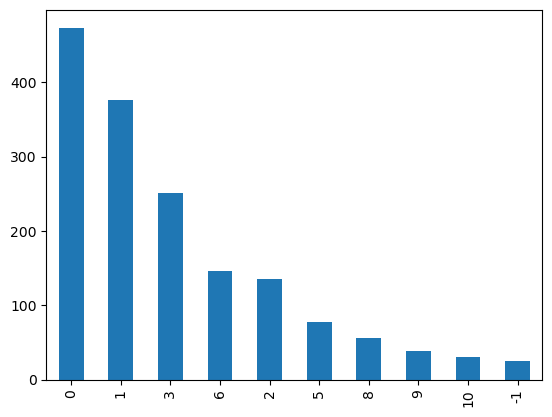

In [83]:
df['topic_id'].value_counts().plot(kind='bar')

In [84]:
df['topic_id'].value_counts()

 0     474
 1     377
 3     251
 6     146
 2     136
 5      77
 8      56
 9      38
 10     30
-1      25
Name: topic_id, dtype: int64

In [85]:
print(f'Final number of Outliers is: {len(df[df["topic_id"]==-1])}')

Final number of Outliers is: 25

In [86]:
print(f'Model used to calculate embeddings is:\n\t===> {model_path} <===')

Model used to calculate embeddings is:
        ===> sentence-transformers/use-cmlm-multilingual <===

########## Topics After Merging From Last Step ##########
0 محتوى ومعلومات المقرر
1 دكتور المقرر
2 None
3 موازنة الجزء العملي مع الجزء النظري 
4 = 2 before merging
5 المتطلبات و المهام و الدرجات
6 طريقة تدريس و تقديم المادة
7 = 9 before merging
8 الوقت و الجدول
9 سوق العمل
10 الجانب البحثي و الأوراق البحثية
###########################################